In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import utils.functions as f

import warnings

warnings.filterwarnings("ignore", message="divide by zero encountered in scalar divide")

c:\Users\Lorenzo\miniconda3\lib\site-packages\torch\_functorch\deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [3]:
dataset = "direct_matching_20240213"  # "direct_matching_20240213" or "reverse_matching_20240213"
df_processed = pd.read_csv(f"Data/{dataset}_processed.csv", sep=";")

### Correlation Matrix

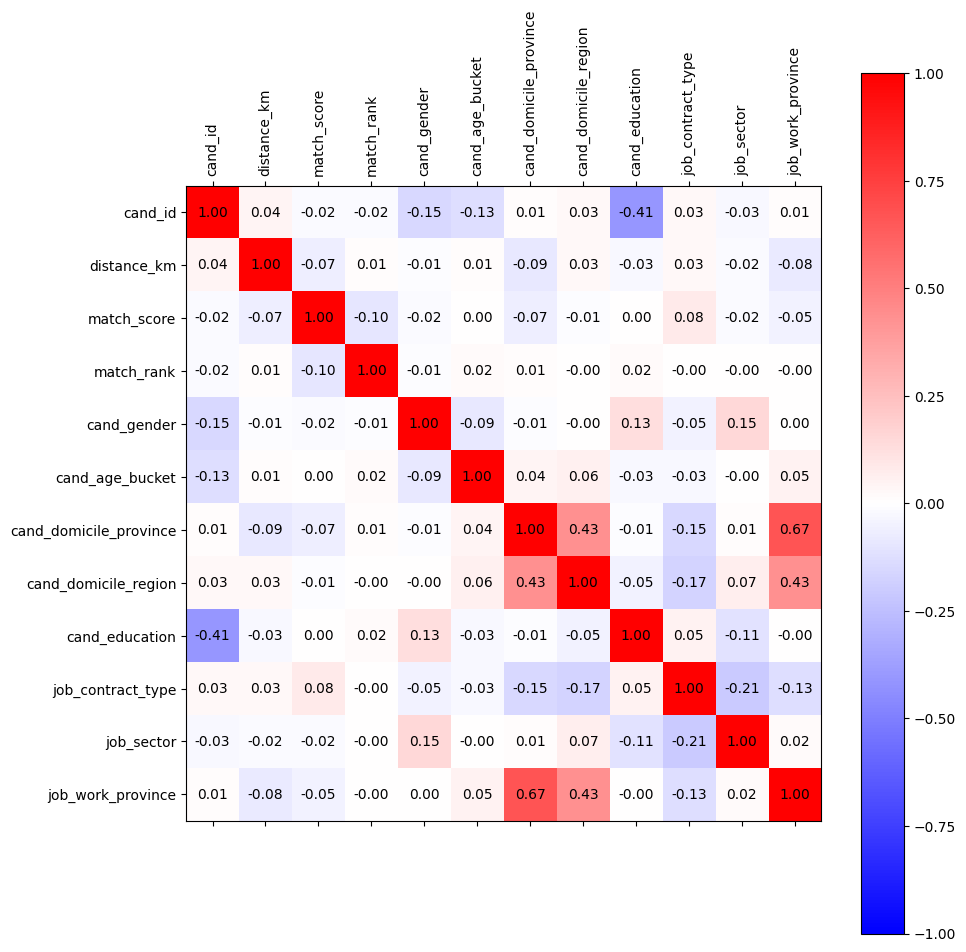

In [30]:
selected_columns = [
    "cand_id",
    "distance_km",
    "match_score",
    "match_rank",
    "cand_gender",
    "cand_age_bucket",
    "cand_domicile_province",
    "cand_domicile_region",
    "cand_education",
    "job_contract_type",
    "job_sector",
    "job_work_province",
]
f.plot_correlation_matrix(df_processed, selected_columns)

# Bias Detection

In [31]:
f.get_sector_metric_optimized(df_processed, "job_sector", 1, "cand_gender")

,Sector,Job,Disparate_Impact,Statistical_Parity_Difference
0,1,OFF_1186_1770,1.479452,0.035515
1,1,OFF_1208_1770,1.479452,0.035515
2,1,OFF_1209_1770,1.479452,0.035515
3,1,OFF_1221_1770,1.479452,0.035515
4,1,OFF_1222_1770,1.479452,0.035515
5,1,OFF_3390_0533,0.554795,-0.065956
6,1,OFF_3472_0533,0.246575,-0.167428
7,1,OFF_3819_0382,0.863014,-0.015221
8,1,OFF_4781_0826,3.328767,0.086251
9,1,OFF_4863_0660,0.863014,-0.015221


In [32]:
f.get_all_sectors_metrics(df_processed)

c:\Users\Lorenzo\Documents\GitHub\AEQUITAS-Debiasing\utils\functions.py:355: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


,Sector,Job,Disparate_Impact,Statistical_Parity_Difference
0,0,OFF_1011_1427,0.880952,-0.001931
1,0,OFF_1216_1626,0.146825,-0.020753
2,0,OFF_14877_0059,0.566327,-0.008205
3,0,OFF_14991_0059,0.880952,-0.001931
4,0,OFF_15007_0059,0.146825,-0.020753
...,...,...,...,...
22,6,ORD_15808_0133,3.089552,0.030283
23,6,ORD_17611_0161,0.800995,-0.008652
24,6,ORD_18473_1389,0.085821,-0.105992
25,6,ORD_18790_0103,inf,0.049751


In [33]:
f.show_bias(df_processed, "cand_gender", 1)

c:\Users\Lorenzo\Documents\GitHub\AEQUITAS-Debiasing\utils\functions.py:300: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


        Disparate_Impact  Statistical_Parity_Difference
Sector                                                 
0               2.095522                      -0.000087
1               1.283582                      -0.003545
2               1.618365                      -0.001454
3               1.668671                      -0.000485
4               1.990807                       0.002138
5               1.609200                       0.000293
6               1.921845                      -0.002273
7               1.670244                      -0.000769
8               1.797275                      -0.000144
9               1.560630                      -0.012066
        Disparate_Impact  Statistical_Parity_Difference
Sector                                                 
0              13.293651                       0.036697
1               3.223881                       0.092662
2               3.532609                       0.019482
3               3.417266                       0

In [19]:
import numpy as np


def get_sector_DIDI(df, sector_column, sector, protected_attribute):
    # Ensure the sector exists in the DataFrame to avoid empty results
    if sector not in df[sector_column].unique():
        raise ValueError(f"Sector '{sector}' not found in the DataFrame.")

    # Pre-filter DataFrame for the sector
    sector_df = df[df[sector_column] == sector]

    # Retrieve unique job IDs for the specified sector
    job_list = sector_df["job_id"].unique()
    job_info_list = []

    # Function to compute DIDI
    def DIDI_r(data, pred, protected):
        res, avg = 0, np.mean(pred)
        for aname, dom in protected.items():
            for val in dom:
                mask = data[aname] == val
                res += abs(avg - np.mean(pred[mask]))
        return res

    for job in job_list:
        # Identify idoneous candidates for the job
        job_df = sector_df.copy()
        job_df["idoneous"] = (job_df["job_id"] == job).astype(int)

        # Drop unnecessary columns
        job_df = job_df.drop(
            columns=[
                "job_id",
                "distance_km",
                "match_score",
                "match_rank",
                "job_contract_type",
                "job_professional_category",
                "job_sector",
                "job_work_province",
                "cand_id",
                "cand_domicile_province",
                "cand_domicile_region",
                "cand_education",
            ]
        )

        # Compute DIDI for the job
        DIDI_result = DIDI_r(job_df, job_df["idoneous"], {protected_attribute: [1]})

        # Store the result
        job_info = {"sector": sector, "job_id": job, "DIDI": DIDI_result}
        job_info_list.append(job_info)

    return pd.DataFrame(job_info_list)


def get_all_sectors_DIDI(
    df, sector_column="job_sector", protected_attribute="cand_gender"
):
    sectors = df[sector_column].unique()
    all_sector_metrics = pd.DataFrame()

    for sector in sectors:
        sector_metrics = get_sector_DIDI(
            df_processed, sector_column, sector, protected_attribute
        )
        all_sector_metrics = pd.concat([all_sector_metrics, sector_metrics], axis=0)

    return all_sector_metrics


all_sector_metrics = get_all_sectors_DIDI(df_processed)

# Display the results grouped by sector
print(all_sector_metrics.drop(columns="job_id").groupby("sector").mean())
print(all_sector_metrics.drop(columns="job_id").groupby("sector").max())

            DIDI
sector          
0       0.006218
1       0.038519
2       0.011163
3       0.015765
4       0.007866
5       0.001403
6       0.028866
7       0.001121
8       0.002155
9       0.022410
            DIDI
sector          
0       0.015385
1       0.122222
2       0.037307
3       0.046429
4       0.026643
5       0.005514
6       0.078905
7       0.003537
8       0.006906
9       0.047173
